# Joensuu Tuiskavanluoto

**Tarkasteluväli:** _1986-1-1_ – _2024-12-31_

<img src="./attachments/13-3-5287105.avif" width="500"/>

Lähde: [Havaintojen lataus - Ilmatieteen Laitos](https://www.ilmatieteenlaitos.fi/havaintojen-lataus)

In [22]:
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt

pl.Config.set_tbl_width_chars(140)
pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_tbl_cols(-1)

polars.config.Config

In [11]:
# Download dataset
source = Path("data/Liperi*")

weather_df = pl.read_csv(source, has_header=True, null_values=["-"])

In [12]:
# Shape and sample
print(weather_df.shape)
print(weather_df.sample(5))

(221993, 13)
┌───────────┬───────┬──────────┬───────┬───────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ Havaintoa ┆ Vuosi ┆ Kuukausi ┆ Päivä ┆ Aika [Pai ┆ Lämpötil ┆ Ylin läm ┆ Alin läm ┆ Keskituu ┆ Tuulen   ┆ Kovin    ┆ Tunnin   ┆ Suhteell │
│ sema      ┆ ---   ┆ ---      ┆ ---   ┆ kallinen  ┆ an keski ┆ pötila   ┆ pötila   ┆ len      ┆ suunnan  ┆ puuska   ┆ sademäär ┆ isen kos │
│ ---       ┆ i64   ┆ i64      ┆ i64   ┆ aika]     ┆ arvo     ┆ [°C]     ┆ [°C]     ┆ nopeus   ┆ keskiarv ┆ [m/s]    ┆ ä [mm]   ┆ teuden   │
│ str       ┆       ┆          ┆       ┆ ---       ┆ [°C]     ┆ ---      ┆ ---      ┆ [m/s]    ┆ o [°]    ┆ ---      ┆ ---      ┆ keskiar… │
│           ┆       ┆          ┆       ┆ str       ┆ ---      ┆ f64      ┆ f64      ┆ ---      ┆ ---      ┆ f64      ┆ str      ┆ ---      │
│           ┆       ┆          ┆       ┆           ┆ f64      ┆          ┆          ┆ f64      ┆ i64      ┆          ┆          ┆ i64      │


In [40]:
# Add "Päivämäärä" column (ISO 8601 date)
weather_df = (
    weather_df
    .with_columns(
        Päivämäärä=pl.date(pl.col("Vuosi"), pl.col("Kuukausi"), pl.col("Päivä"))
    )
    .sort("Päivämäärä")
)

In [46]:
# Min and max dates
min_date = weather_df.select("Päivämäärä").min().item()
max_date = weather_df.select("Päivämäärä").max().item()

print(f"Date range for observations: {min_date} – {max_date}")

Date range for observations: 1997-08-25 – 2023-07-12


In [51]:
# Print schema
for key, value in weather_df.schema.items():
    print(f"\"{key}\": {value}")

"Havaintoasema": String
"Vuosi": Int64
"Kuukausi": Int64
"Päivä": Int64
"Aika [Paikallinen aika]": String
"Lämpötilan keskiarvo [°C]": Float64
"Ylin lämpötila [°C]": Float64
"Alin lämpötila [°C]": Float64
"Keskituulen nopeus [m/s]": Float64
"Tuulen suunnan keskiarvo [°]": Int64
"Kovin puuska [m/s]": Float64
"Tunnin sademäärä [mm]": String
"Suhteellisen kosteuden keskiarvo [%]": Int64
"Päivämäärä": Date


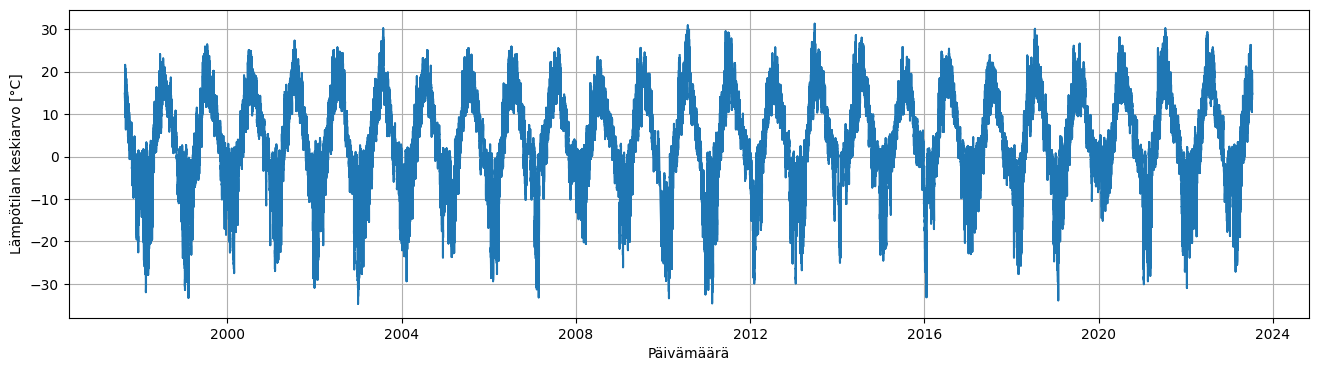

In [64]:
# plot
x = weather_df.select("Päivämäärä").to_series()
y = weather_df.select("Lämpötilan keskiarvo [°C]").to_series()

fig, ax = plt.subplots(figsize=(16, 4))
ax.grid(visible=True)
ax.plot(x,y)

ax.set_xlabel("Päivämäärä")
ax.set_ylabel("Lämpötilan keskiarvo [°C]")

plt.show()

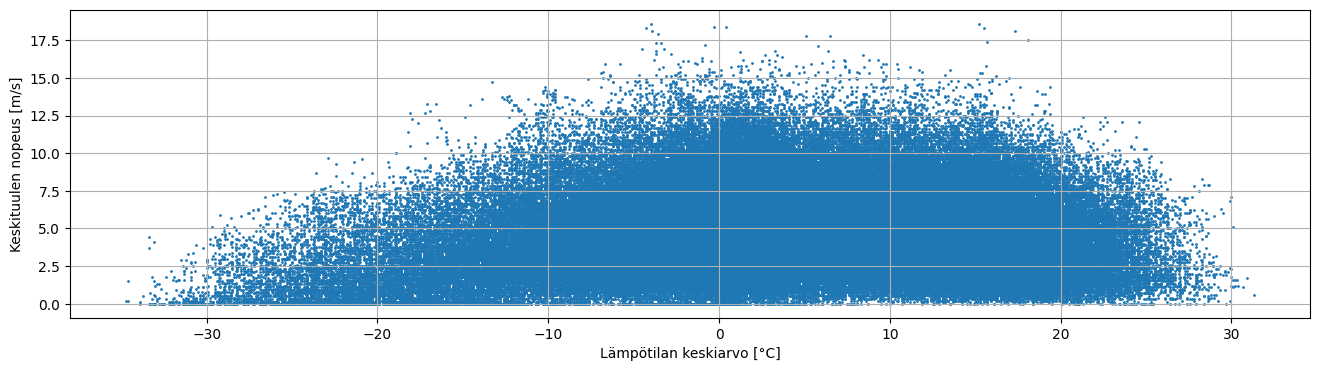

In [62]:
# Scatter plot
x = weather_df.select("Lämpötilan keskiarvo [°C]").to_series()
y = weather_df.select("Keskituulen nopeus [m/s]").to_series()

fig, ax = plt.subplots(figsize=(16, 4))
ax.grid(visible=True)
ax.scatter(x,y, s=1)

ax.set_xlabel("Lämpötilan keskiarvo [°C]")
ax.set_ylabel("Keskituulen nopeus [m/s]")

plt.show()

## The components of a Matplotlib Figure

Here are the components of a Matplotlib Figure.

<img src="./attachments/anatomy.webp" width="700"/>

Source: [Matplotlib - Parts of a Figure](https://matplotlib.org/stable/users/explain/quick_start.html#parts-of-a-figure)